# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [26]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 
import scipy.ndimage
from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [27]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0207/npy_2/'
test_path='/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0207/test_data/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 22.29it/s]


Now all merge samples are saved!


In [28]:
# get all npy files
## The ratio can also be changed


t_dir_samples = test_path + "/*.npy"
te_samples = glob.glob(t_dir_samples)

# merge them
test_samples = np.load(te_samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(te_samples[1:])):
    try:
        test_samples = np.concatenate(
            (test_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(test_samples,)


# define the train/valid path
test_samples_merge_path = test_path + "merge/test_merge.npy"

np.save(test_samples_merge_path, test_samples)

print("Now all merge samples are saved!")


4it [00:00, 90.14it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [29]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)
test_merge = np.load(test_samples_merge_path,allow_pickle=True)
print (np.array(test_merge).shape)

(2784, 1, 2)
(697, 1, 2)
(490, 1, 2)


In [30]:
kernel=24
bands=30
minkernel=36
input_size=( minkernel,minkernel,bands)
output_size = 5+1
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)



Post-processed S2_train data shape:  (2784, 17280)


In [31]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)
X_val_rf = np.reshape(X_val, (number_samples, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (697, 17280)


In [32]:

number_samples = test_merge.shape[0]
data_test = test_merge[:,:,0]
X_test= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    x = data_test[i,0]
    X_test[i,:] = x[:,:,0:30]
Y_test = np.reshape(test_merge[:,:,1],number_samples).astype(int)
X_test_rf = np.reshape(X_test, (number_samples, kernel*kernel*bands))

print("Post-processed S2_val data shape: ", X_test_rf.shape,X_test.shape)

Post-processed S2_val data shape:  (490, 17280) (490, 24, 24, 30)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [33]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [34]:
y_pred_rf = rf_classifier.predict(X_val_rf)

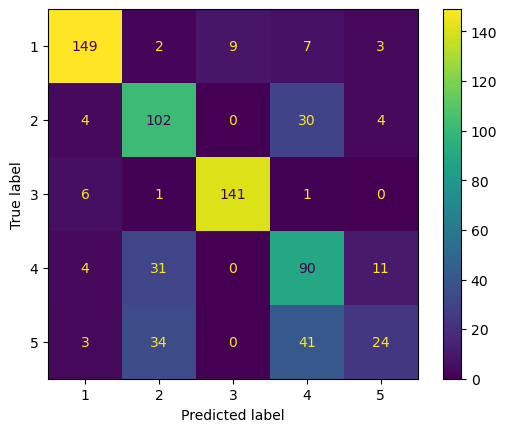

Accuracy Random Forest Classifier:  0.7259684361549498


In [35]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [36]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2784, 576, 30)


In [37]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_val data shape: ", X_val_nn.shape)

Post-processed S2_val data shape:  (697, 576, 30)


In [38]:
number_samples = X_test.shape[0]
X_test_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_test_nn[i,:] = np.reshape(X_test[i,:], (  kernel*kernel,bands))
    X_test_nn[i,:]= np.array(pd.DataFrame(X_test_nn[i,:]).fillna(0))
print("Post-processed S2_test data shape: ", X_test_nn.shape)

Post-processed S2_test data shape:  (490, 576, 30)


In [39]:

number_samples = X_train.shape[0]
X_train_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,bands):
        tile= np.array(X_train[i,:,:,j])
        X_train_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_train_nn2.shape)

Post-processed S2_train data shape:  (2784, 36, 36, 30)


In [40]:

number_samples = X_val.shape[0]
X_val_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,bands):
        tile= np.array(X_val[i,:,:,j])
        X_val_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_val_nn2.shape)

Post-processed S2_train data shape:  (697, 36, 36, 30)


In [41]:

number_samples = X_test.shape[0]
X_test_nn2= np.zeros((number_samples,  minkernel,minkernel,bands), dtype=float)
for i in range(0,number_samples-1):
    for j in range(0,bands):
        tile= np.array(X_test[i,:,:,j])
        X_test_nn2[i,:,:,j]= scipy.ndimage.zoom(tile, 1.5, order=1)
print("Post-processed S2_train data shape: ", X_test_nn2.shape)

Post-processed S2_train data shape:  (490, 36, 36, 30)


In [42]:
base_model =tf.keras.applications.MobileNetV2(
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=None,input_shape=(  minkernel,minkernel,3), pooling=None, classes=output_size)
   
    

base_model.trainable = False
base_learning_rate = 0.0001

In [43]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [44]:
EarlyStopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.005,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)
EarlyStopping3=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.005,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False
    #start_from_epoch=10
)

In [45]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=input_size),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
history = simple_model.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))

Epoch 1/100


2023-02-07 01:42:30.673393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:42:32.095076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 21ms/sample - loss: 4.4085 - accuracy: 0.3495 - val_loss: 1.4149 - val_accuracy: 0.4060
Epoch 21/100
87/87 [==============================] - 1s 14ms/sample - loss: 1.0915 - accuracy: 0.5040 - val_loss: 1.0243 - val_accuracy: 0.5581
Epoch 41/100
87/87 [==============================] - 1s 13ms/sample - loss: 0.9694 - accuracy: 0.5366 - val_loss: 0.9081 - val_accuracy: 0.5825
Epoch 61/100
87/87 [==============================] - 1s 14ms/sample - loss: 1.0436 - accuracy: 0.4993 - val_loss: 0.9559 - val_accuracy: 0.5466


In [47]:
y_pred_dl_p = simple_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

22/22 [==============================] - 0s 8ms/step
Prediction example:  [5.8219439e-34 4.6310404e-01 7.7842649e-10 5.3689259e-01 1.3307960e-06
 1.9714334e-06]  Class:  3


2023-02-07 01:43:57.209535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


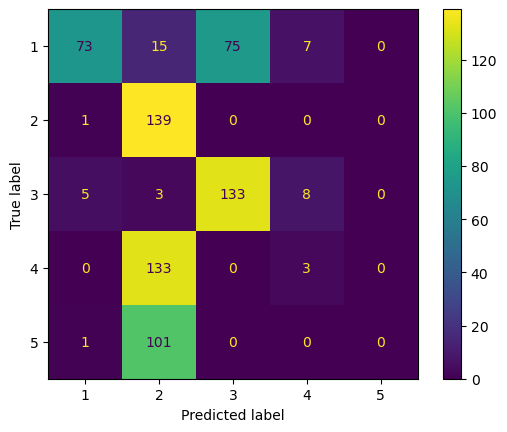

Accuracy Simple Deep Learning model:  0.49928263988522237


In [48]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

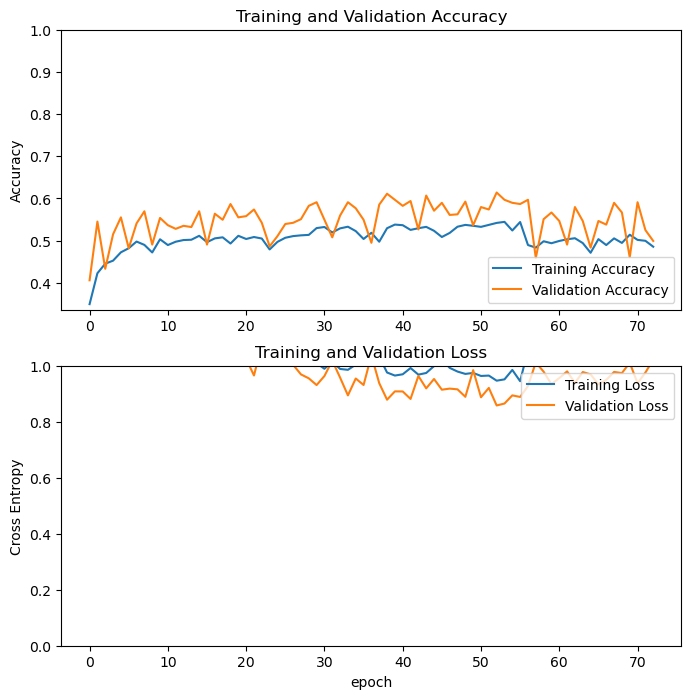

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [50]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

simple_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
simple_model.summary()
len(simple_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 38880)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4976768   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4,977,542
Trainable params: 4,977,542
Non-trainable params: 0
_________________________________________________________________


4

In [51]:
fine_tune_epochs = 10
initial_epochs = max(history.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=[EarlyStopping2],
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 73/82


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-07 01:43:58.391470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/87 [============================>.] - ETA: 0s - loss: 1.0363 - accuracy: 0.4669

2023-02-07 01:43:59.790160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 17ms/step - loss: 1.0365 - accuracy: 0.4670 - val_loss: 0.9847 - val_accuracy: 0.5294
Epoch 74/82
87/87 [==============================] - 1s 16ms/step - loss: 1.0239 - accuracy: 0.4774 - val_loss: 0.9714 - val_accuracy: 0.5524
Epoch 75/82
87/87 [==============================] - 1s 15ms/step - loss: 1.0128 - accuracy: 0.4978 - val_loss: 0.9629 - val_accuracy: 0.5825
Epoch 76/82
87/87 [==============================] - 1s 15ms/step - loss: 1.0105 - accuracy: 0.5086 - val_loss: 0.9581 - val_accuracy: 0.5925
Epoch 77/82
87/87 [==============================] - 1s 15ms/step - loss: 1.0017 - accuracy: 0.5172 - val_loss: 0.9570 - val_accuracy: 0.5897
Epoch 78/82
87/87 [==============================] - 1s 15ms/step - loss: 1.0036 - accuracy: 0.5244 - val_loss: 0.9548 - val_accuracy: 0.5868
Epoch 79/82
87/87 [==============================] - 1s 15ms/step - loss: 1.0100 - accuracy: 0.5162 - val_loss: 0.9521 - val_accuracy: 0.5868
Epoch 80/82
87/87 

In [52]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

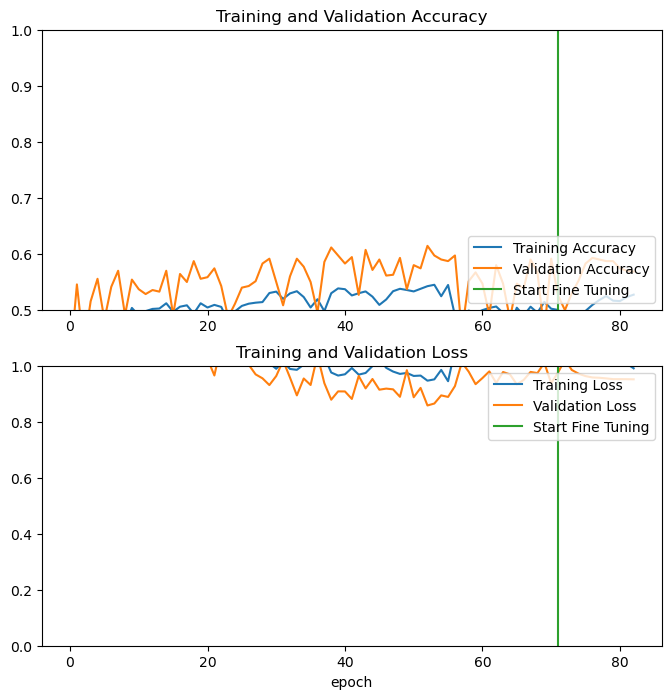

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [54]:
loss, accuracy = simple_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 11ms/step - loss: 0.9514 - accuracy: 0.5681
Test accuracy : 0.568149209022522


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [55]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=input_size),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(128, (1,1), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
    
]
)

In [56]:

CNNs_model.summary() 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        8672      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

In [57]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dropout(0.5))
CNNs_model.add(layers.Dense(output_size))

In [58]:

CNNs_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        8672      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)       

In [59]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn2, Y_train, epochs=50,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping2],  verbose=0,
                    validation_data=(X_val_nn2, Y_val))
     

Epoch 1/50


2023-02-07 01:44:13.435351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:44:15.082625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 24ms/sample - loss: 1.4067 - accuracy: 0.3434 - val_loss: 1.1275 - val_accuracy: 0.3945
Epoch 11/50
87/87 [==============================] - 1s 12ms/sample - loss: 0.8152 - accuracy: 0.6279 - val_loss: 0.8084 - val_accuracy: 0.6069
Epoch 21/50
87/87 [==============================] - 1s 12ms/sample - loss: 0.6672 - accuracy: 0.7166 - val_loss: 0.7205 - val_accuracy: 0.6700


In [60]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn2)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

22/22 [==============================] - 0s 5ms/step
Prediction example:  [-21.82219     7.769001  -12.277935    1.2626628  -3.3984756  -6.7137337]  Class:  1


2023-02-07 01:44:43.892144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


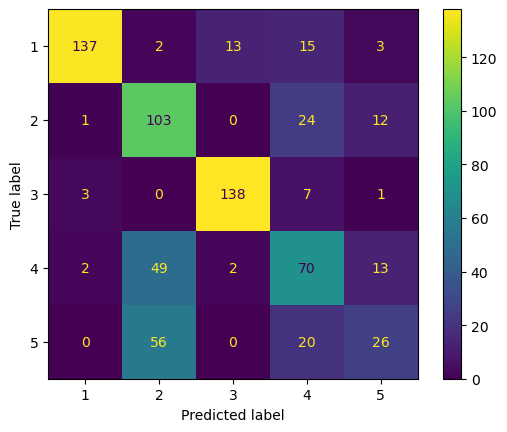

Accuracy Simple Deep Learning model:  0.6800573888091822


In [61]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

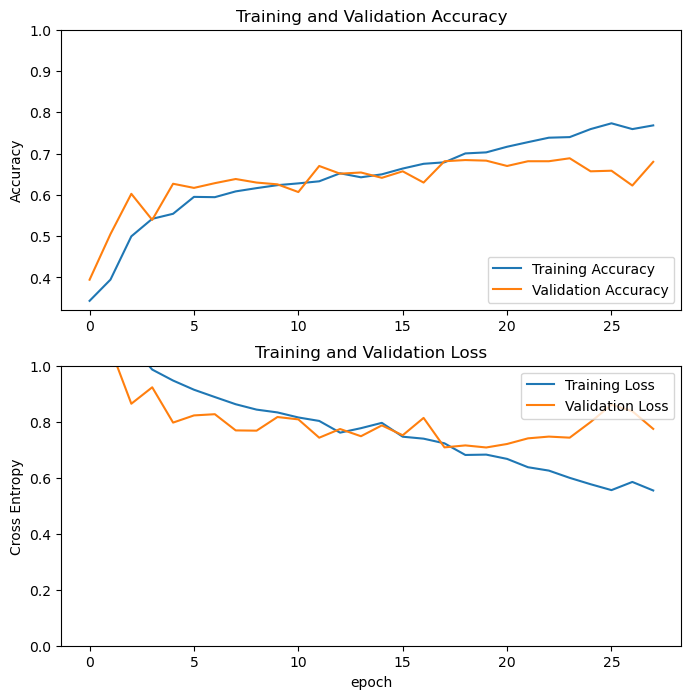

In [62]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

CNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
CNNs_model.summary()
len(CNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        8672      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 max_pooling2

14

In [64]:

fine_tune_epochs = 10
initial_epochs = max(history2.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = CNNs_model.fit(X_train_nn2,Y_train,
                         epochs=total_epochs,callbacks=EarlyStopping3,
                         initial_epoch=history2.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 28/37


2023-02-07 01:44:45.106042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


84/87 [===========================>..] - ETA: 0s - loss: 0.4662 - accuracy: 0.8125

2023-02-07 01:44:46.998207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 18ms/step - loss: 0.4648 - accuracy: 0.8147 - val_loss: 0.7288 - val_accuracy: 0.6944
Epoch 29/37
87/87 [==============================] - 1s 15ms/step - loss: 0.4456 - accuracy: 0.8308 - val_loss: 0.7219 - val_accuracy: 0.6958
Epoch 30/37
87/87 [==============================] - 1s 15ms/step - loss: 0.4274 - accuracy: 0.8405 - val_loss: 0.7210 - val_accuracy: 0.6887
Epoch 31/37
87/87 [==============================] - 1s 15ms/step - loss: 0.4166 - accuracy: 0.8484 - val_loss: 0.7204 - val_accuracy: 0.6858
Epoch 32/37
87/87 [==============================] - 1s 15ms/step - loss: 0.4200 - accuracy: 0.8416 - val_loss: 0.7223 - val_accuracy: 0.6930
Epoch 33/37
87/87 [==============================] - 1s 16ms/step - loss: 0.4071 - accuracy: 0.8524 - val_loss: 0.7236 - val_accuracy: 0.6901
Epoch 34/37
87/87 [==============================] - 1s 15ms/step - loss: 0.4100 - accuracy: 0.8502 - val_loss: 0.7240 - val_accuracy: 0.6901
Epoch 35/37
87/87 

In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

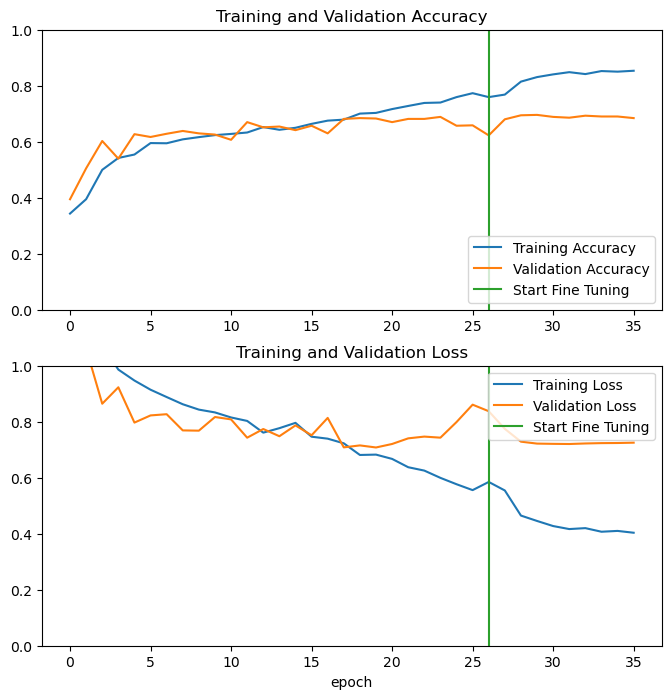

In [66]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [67]:
loss, accuracy = CNNs_model.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 7ms/step - loss: 0.7252 - accuracy: 0.6844
Test accuracy : 0.6843615770339966


# Step 6. - Residual Network: ResNet

A residual neural network (ResNet) is an artificial neural network that imitate the pyramidal cells in the cerebral cortex. Particularly, the ResNet architecture consists of skip connections or shortcuts to jump over some layers. Typical ResNet models are implemented with double- or triple- layer skips that contain nonlinearities (ReLU) and batch normalization in between. These *cells* are known as *residual block*.

ResNets connection weights are easier to optimize (especially for gradient descent-based optimizers) because the short cuts contribute to alleviate the vanishing gradient problem.

In practice, the degradation problem (i.e., increasing the depth of a network leads to a decrease in its performance) is mitigated, and the observed performance (when the number of hidden layers increase) is much closer to the theoretical one.

In [68]:
model_rn = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=input_size, 
    pooling=None,
    classes=output_size)

model_rn.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'])

/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/applications/resnet.py:159: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 30 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [69]:
history3=model_rn.fit(X_train_nn2, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0,validation_data=(X_val_nn2, Y_val))


Epoch 1/100


2023-02-07 01:45:00.354595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:45:11.342094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 15s 173ms/sample - loss: 1.3972 - accuracy: 0.4928 - val_loss: 1.6974 - val_accuracy: 0.1951
Epoch 11/100
87/87 [==============================] - 7s 77ms/sample - loss: 0.6664 - accuracy: 0.7457 - val_loss: 1.8884 - val_accuracy: 0.5065
Epoch 21/100
87/87 [==============================] - 7s 78ms/sample - loss: 1.1396 - accuracy: 0.6060 - val_loss: 7.6488 - val_accuracy: 0.2166
Epoch 31/100
87/87 [==============================] - 7s 76ms/sample - loss: 0.7163 - accuracy: 0.7536 - val_loss: 1.6488 - val_accuracy: 0.5136
Epoch 41/100
87/87 [==============================] - 7s 76ms/sample - loss: 0.8158 - accuracy: 0.6642 - val_loss: 6.3370 - val_accuracy: 0.6112


2023-02-07 01:50:13.163655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 41ms/step


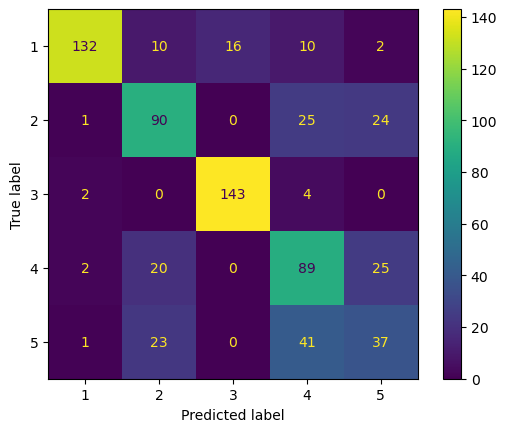

Accuracy ResNet-50 model:  0.7044476327116213


In [70]:
y_pred_rn_p = model_rn.predict(X_val_nn2)

y_pred_rn = np.argmax(y_pred_rn_p, axis=1)

##print(y_pred_rn)
#print(Y_val)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rn)
plt.show()

acc_rn = accuracy_score(Y_val, y_pred_rn)
print("Accuracy ResNet-50 model: ", acc_rn)

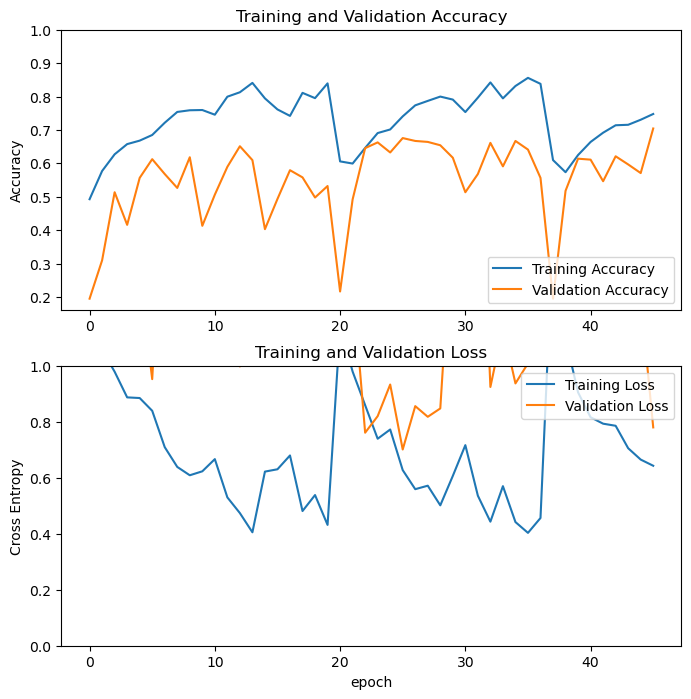

In [71]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model_rn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model_rn.summary()
len(model_rn.trainable_variables)

Number of layers in the base model:  154
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 36, 36, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 42, 42, 30)   0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 18, 18, 64)   94144       ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 18, 18, 64)

214

In [73]:
fine_tune_epochs = 10
initial_epochs = max(history3.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_rn.fit(X_train_nn2,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping3,
                         initial_epoch=history3.epoch[-1],
                         validation_data=(X_val_nn2,Y_val))

Epoch 46/55


/Users/siruiwang/miniforge3/envs/tf261/lib/python3.8/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-02-07 01:50:18.418896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.8021

2023-02-07 01:50:39.267580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 25s 151ms/step - loss: 0.4810 - accuracy: 0.8021 - val_loss: 0.6720 - val_accuracy: 0.7202
Epoch 47/55
87/87 [==============================] - 12s 134ms/step - loss: 0.4621 - accuracy: 0.8071 - val_loss: 0.6611 - val_accuracy: 0.7389
Epoch 48/55
87/87 [==============================] - 10s 121ms/step - loss: 0.4544 - accuracy: 0.8157 - val_loss: 0.6670 - val_accuracy: 0.7317
Epoch 49/55
87/87 [==============================] - 10s 120ms/step - loss: 0.4436 - accuracy: 0.8182 - val_loss: 0.6806 - val_accuracy: 0.7360
Epoch 50/55
87/87 [==============================] - 10s 119ms/step - loss: 0.4143 - accuracy: 0.8326 - val_loss: 0.6985 - val_accuracy: 0.7288
Epoch 51/55
87/87 [==============================] - 10s 119ms/step - loss: 0.4118 - accuracy: 0.8358 - val_loss: 0.7180 - val_accuracy: 0.7331


In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

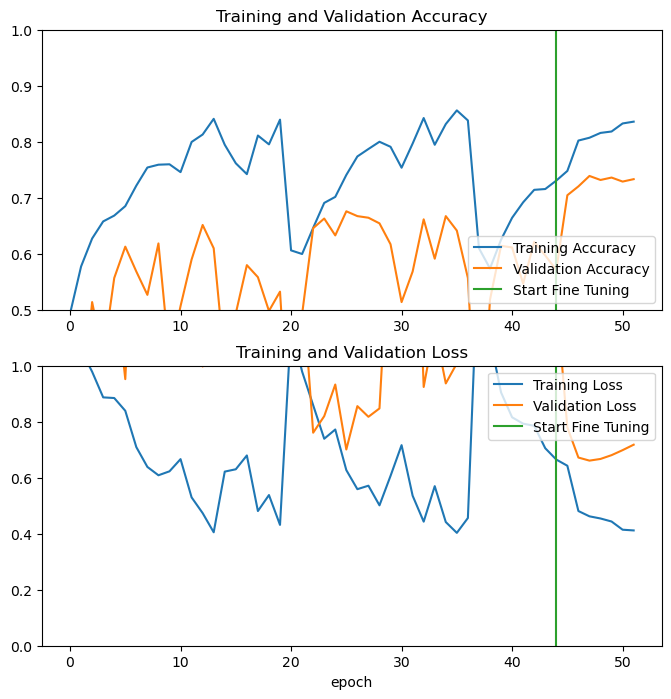

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
loss, accuracy = model_rn.evaluate(X_val_nn2,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 1s 24ms/step - loss: 0.7180 - accuracy: 0.7331
Test accuracy : 0.7331420183181763


# Step 7. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [77]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = bands

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [78]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history5=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=10),EarlyStopping],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-02-07 01:51:36.126556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:51:36.294197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:51:38.771166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:51:55.539280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:51:55.610357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 24s 535ms/sample - loss: 1.5219 - accuracy: 0.3962 - val_loss: 1.7130 - val_accuracy: 0.2209
Epoch 11/100
44/44 [==============================] - 7s 151ms/sample - loss: 1.0907 - accuracy: 0.5553 - val_loss: 1.3918 - val_accuracy: 0.3587
Epoch 21/100
44/44 [==============================] - 7s 151ms/sample - loss: 1.0255 - accuracy: 0.5812 - val_loss: 1.3195 - val_accuracy: 0.4419
Epoch 31/100
44/44 [==============================] - 7s 158ms/sample - loss: 0.9929 - accuracy: 0.5938 - val_loss: 4.3322 - val_accuracy: 0.3300
Epoch 41/100
44/44 [==============================] - 7s 156ms/sample - loss: 1.0447 - accuracy: 0.5823 - val_loss: 1.2656 - val_accuracy: 0.4605
Epoch 51/100
44/44 [==============================] - 7s 156ms/sample - loss: 0.9013 - accuracy: 0.6261 - val_loss: 1.4057 - val_accuracy: 0.5179
Epoch 61/100
44/44 [==============================] - 7s 157ms/sample - loss: 0.8340 - accuracy: 0.6422 - val_loss: 2.5340 - val_accurac

In [79]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

2023-02-07 01:59:42.671627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:59:42.735778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 4s 140ms/step
Prediction example:  [ -2.0438957  11.251534   -7.274864   16.149498  -14.405407   -9.282185 ]  Class:  3


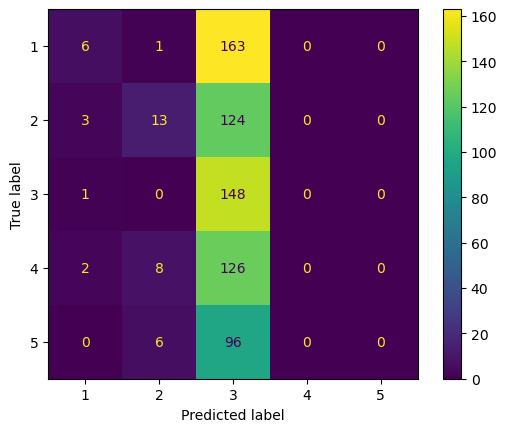

Accuracy Simple Deep Learning model:  0.23959827833572453


In [80]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

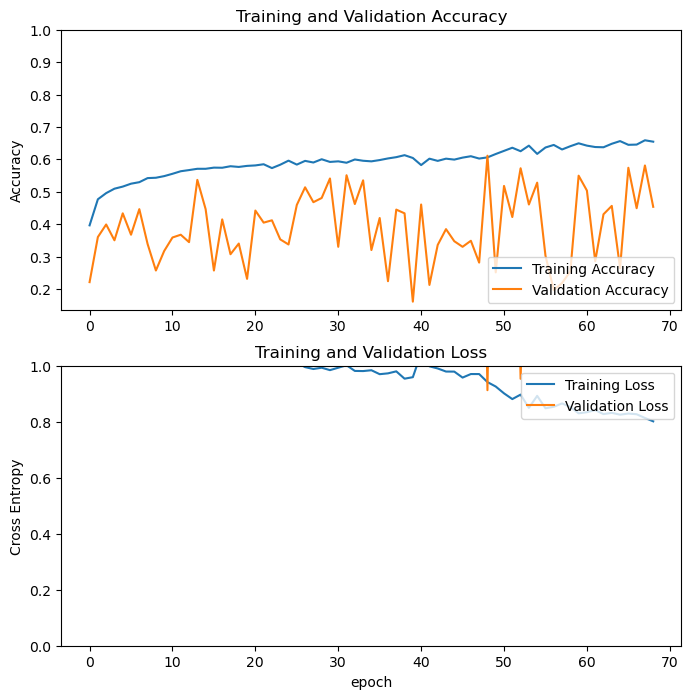

In [81]:

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [82]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

RNNs_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
RNNs_model.summary()
len(RNNs_model.trainable_variables)

Number of layers in the base model:  154
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24320     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_8 (Dense)             (None, 6)                 390       
                                                                 
Total params: 24,966
Trainable params: 24,838
Non-trainable params: 128
_________________________________________________________________


7

In [83]:
fine_tune_epochs = 15
initial_epochs = max(history5.epoch)
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = RNNs_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs, callbacks=EarlyStopping2,
                         initial_epoch=history5.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 69/83


2023-02-07 01:59:47.952485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:59:48.113249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 01:59:49.546368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - ETA: 0s - loss: 0.9283 - accuracy: 0.5981

2023-02-07 02:00:05.360233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 02:00:05.439466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 22s 185ms/step - loss: 0.9283 - accuracy: 0.5981 - val_loss: 2.1511 - val_accuracy: 0.4146
Epoch 70/83
87/87 [==============================] - 13s 149ms/step - loss: 0.8878 - accuracy: 0.6200 - val_loss: 1.0404 - val_accuracy: 0.5768
Epoch 71/83
87/87 [==============================] - 13s 154ms/step - loss: 0.8625 - accuracy: 0.6311 - val_loss: 0.8700 - val_accuracy: 0.6198
Epoch 72/83
87/87 [==============================] - 14s 160ms/step - loss: 0.8386 - accuracy: 0.6419 - val_loss: 0.8452 - val_accuracy: 0.6241
Epoch 73/83
87/87 [==============================] - 14s 158ms/step - loss: 0.8281 - accuracy: 0.6444 - val_loss: 0.8428 - val_accuracy: 0.6356
Epoch 74/83
87/87 [==============================] - 14s 157ms/step - loss: 0.8163 - accuracy: 0.6523 - val_loss: 0.8340 - val_accuracy: 0.6413
Epoch 75/83
87/87 [==============================] - 14s 157ms/step - loss: 0.8099 - accuracy: 0.6519 - val_loss: 0.8326 - val_accuracy: 0.6456
Epoc

In [84]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

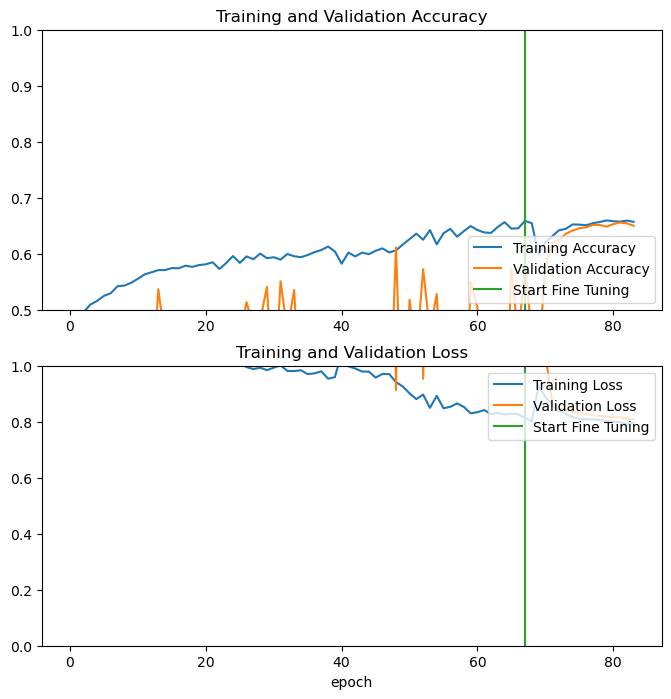

In [85]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [86]:
loss, accuracy = RNNs_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 2s 87ms/step - loss: 0.8092 - accuracy: 0.6499
Test accuracy : 0.6499282717704773


# Step 8. Decision fusion for deep learning methods

In [87]:
def normalized(data):

    normalizedData = data/np.linalg.norm(data)
    return normalizedData

In [88]:

y_pred_dl_p_2 = simple_model.predict(X_val_nn2)
y_pred_cnn_p_2 = CNNs_model.predict(X_val_nn2)
y_pred_rn_p_2 = model_rn.predict(X_val_nn2)
y_pred_rnn_p_2 = RNNs_model.predict(X_val_nn)

13/22 [================>.............] - ETA: 0s

2023-02-07 02:03:22.610626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17/22 [======================>.......] - ETA: 0s

2023-02-07 02:03:22.994018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 10ms/step


2023-02-07 02:03:23.635918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 2s 44ms/step


2023-02-07 02:03:25.509049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-07 02:03:25.559352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 5s 148ms/step


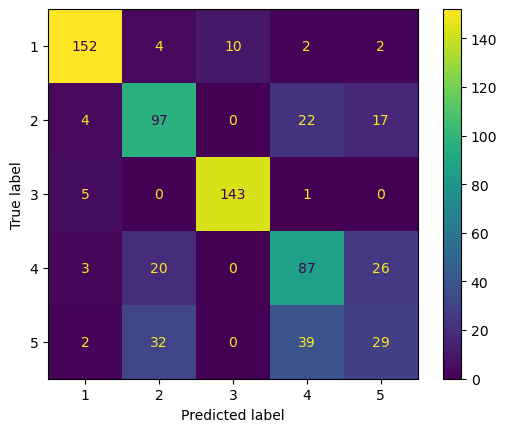

Accuracy Simple Deep Learning model:  0.7288378766140603


In [89]:

#fusion"""y_pred_dl_p_2 +
fusion_softmax = normalized(y_pred_cnn_p_2) + normalized(y_pred_rn_p_2) + normalized(y_pred_rnn_p_2)
fusion_label = np.argmax(fusion_softmax,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_val, fusion_label)
plt.show()

acc_dl = accuracy_score(Y_val, fusion_label)
print("Accuracy Simple Deep Learning model: ", acc_dl)

# Step 9. Test data prediction

16/16 [==============================] - 3s 178ms/step


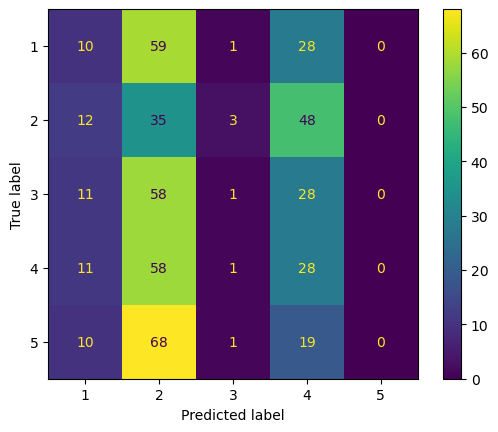

Accuracy Simple Deep Learning model:  0.1510204081632653


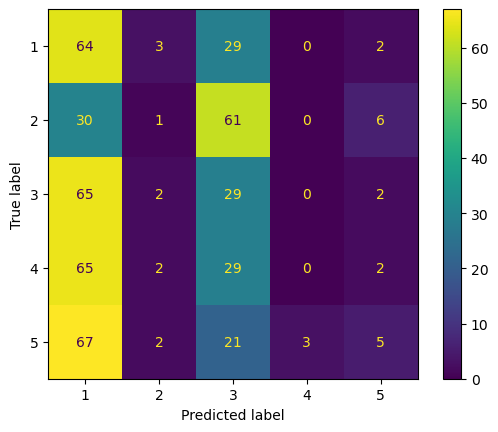

Accuracy Convolutional Neural Network model:  0.20204081632653062


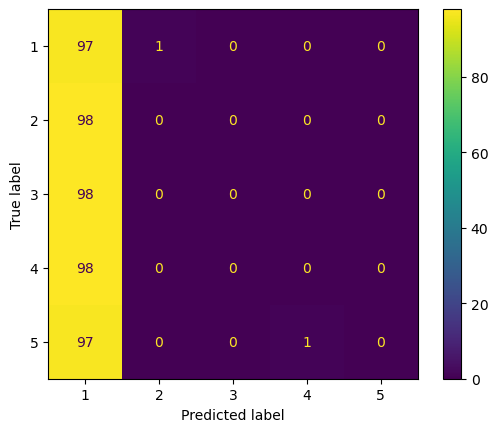

Accuracy Resnet50 model:  0.19795918367346937


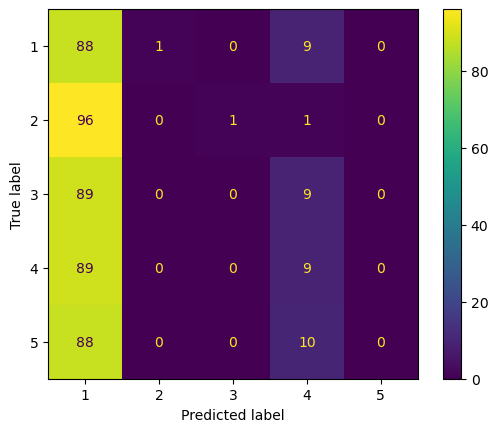

Accuracy RNN model:  0.19795918367346937


In [90]:
y_pred_dl_p_3 = simple_model.predict(X_test_nn2)
y_pred_cnn_p_3 = CNNs_model.predict(X_test_nn2)
y_pred_rn_p_3 = model_rn.predict(X_test_nn2)
y_pred_rnn_p_3 = RNNs_model.predict(X_test_nn)
y_pred_dl_3 = np.argmax(y_pred_dl_p_3,axis=1).astype(np.int16)
y_pred_cnn_3 = np.argmax(y_pred_cnn_p_3,axis=1).astype(np.int16)
y_pred_rn_3 = np.argmax(y_pred_rn_p_3,axis=1).astype(np.int16)
y_pred_rnn_3 = np.argmax(y_pred_rnn_p_3,axis=1).astype(np.int16)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_dl_3)
plt.show()
acc_dl_3 = accuracy_score(Y_test, y_pred_dl_3)
print("Accuracy Simple Deep Learning model: ", acc_dl_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_cnn_3)
plt.show()
acc_cnn_3 = accuracy_score(Y_test, y_pred_cnn_3)
print("Accuracy Convolutional Neural Network model: ", acc_cnn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rn_3)
plt.show()
acc_rn_3 = accuracy_score(Y_test, y_pred_rn_3)
print("Accuracy Resnet50 model: ", acc_rn_3)

ConfusionMatrixDisplay.from_predictions(Y_test, y_pred_rnn_3)
plt.show()
acc_rnn_3 = accuracy_score(Y_test, y_pred_rnn_3)
print("Accuracy RNN model: ", acc_rnn_3)

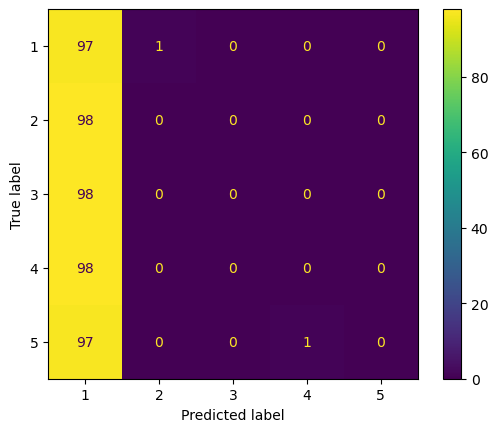

Accuracy Simple Deep Learning model:  0.19795918367346937


In [91]:
#fusion"""y_pred_dl_p_2 +
fusion_softmax_t = normalized(y_pred_cnn_p_3)  + normalized(y_pred_rn_p_3) + normalized(y_pred_rnn_p_3)
fusion_label_t = np.argmax(fusion_softmax_t,axis=1).astype(np.int16)
ConfusionMatrixDisplay.from_predictions(Y_test, fusion_label_t)
plt.show()

acc_dl = accuracy_score(Y_test, fusion_label_t)
print("Accuracy Simple Deep Learning model: ", acc_dl)